<a href="https://colab.research.google.com/github/Crescent-Saturn/Objectness-Heat-Map/blob/master/Demo_Objectness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.models.detection.rpn as rpn
import torchvision.models.detection.image_list as image_list
from torchvision import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Retina display for figure
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# display all outputs instead of last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# some helper functions
# show the feature maps
def show_features(img, features, ch_idx, save=False):
    fig, axes = plt.subplots(2, 3, figsize=(16,9))

    axes[0,0].imshow(img)
    axes[0,0].set_title('Input image')

    # axes[0,1].imshow(img.resize((img.size[0]//4, img.size[1]//4)), alpha=0.9)
    axes[0,1].imshow(features['0'][0, ch_idx, :, :].detach().numpy(), cmap='jet')#, alpha=0.5)
    axes[0,1].set_title('P2')

    axes[0,2].imshow(features['1'][0, ch_idx, :, :].detach().numpy(), cmap='jet')
    axes[0,2].set_title('P3')

    axes[1,0].imshow(features['2'][0, ch_idx, :, :].detach().numpy(), cmap='jet')
    axes[1,0].set_title('P4')

    axes[1,1].imshow(features['3'][0, ch_idx, :, :].detach().numpy(), cmap='jet')
    axes[1,1].set_title('P5')

    axes[1,2].imshow(features['pool'][0, ch_idx, :, :].detach().numpy(), cmap='jet')
    axes[1,2].set_title('P6')

    if save:
        plt.savefig('feature_results.png', bbox_inches='tight')


# show the heat maps
def show_objectness(img, objectness, ch_idx, save=False):
    # same extent needs to be defined for different images
    # extent = 0, objectness[0][0, ch_idx, :, :].shape[1], 0, objectness[0][0, ch_idx, :, :].shape[0]
    # (width, height) = (img.width // 4, img.height // 4)

    fig, axes = plt.subplots(2, 3, figsize=(16,9))

    axes[0,0].imshow(img)
    axes[0,0].set_title('Input image')

    # axes[0,1].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[0,1].imshow(objectness[0][0, ch_idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[0,1].set_title('objectness on P2')

    # axes[0,2].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[0,2].imshow(objectness[1][0, ch_idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[0,2].set_title('objectness on P3')

    # axes[1,0].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,0].imshow(objectness[2][0, ch_idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,0].set_title('objectness on P4')

    # axes[1,1].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,1].imshow(objectness[3][0, ch_idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,1].set_title('objectness on P5')

    # axes[1,2].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,2].imshow(objectness[4][0, ch_idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,2].set_title('objectness on P6')

    if save:
        plt.savefig('objectness_results.png', bbox_inches='tight')


## Construct the Objectness class with nn.ModuleList

In [3]:
# define an objectness class
class Objectness(nn.Module):
    """Ojbectness class, as a PyTorch nn.Module. Using a pre-trained faster-RCNN model
    to obtain the objectness heat maps.

    :param model: a pre-trained faster-rcnn model as initialization
    :type : nn.Module
    :input : a PIL image
    :output : a dict data with 'feature maps' and 'objectness' inside
    """

    def __init__(self, model):
        super(Objectness, self).__init__()

        layers = nn.ModuleList(list(model.children())[1:3])
        self.feature = layers[0].eval()
        self.objectness = layers[1].eval()

    def forward(self, x):
        results = {}

        feature_out = self.feature(x)

        objectness, _ = self.objectness.head(feature_out.values())
        object_out = [self._process(obj) for obj in objectness]

        results['features'] = feature_out
        results['objectness'] = object_out

        return results

    def _process(self, objectness):
        # apply sigmoid
        objectness = torch.sigmoid(objectness)
        # scale to [0,255]
        objectness = torch.round(objectness * 255)
        # convert to numpy
        objectness = objectness.detach().numpy()

        return objectness

## Get the pre-trained model from torchvision

In [4]:
# Get the whole FRCNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [5]:
# Reconstruct the modules required for objectness heatmap
net = Objectness(model)

### Find an image for test

In [6]:
! wget -O test.jpeg https://miro.medium.com/max/1744/1*EYFejGUjvjPcc4PZTwoufw.jpeg 

'wget' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


(900, 1350)

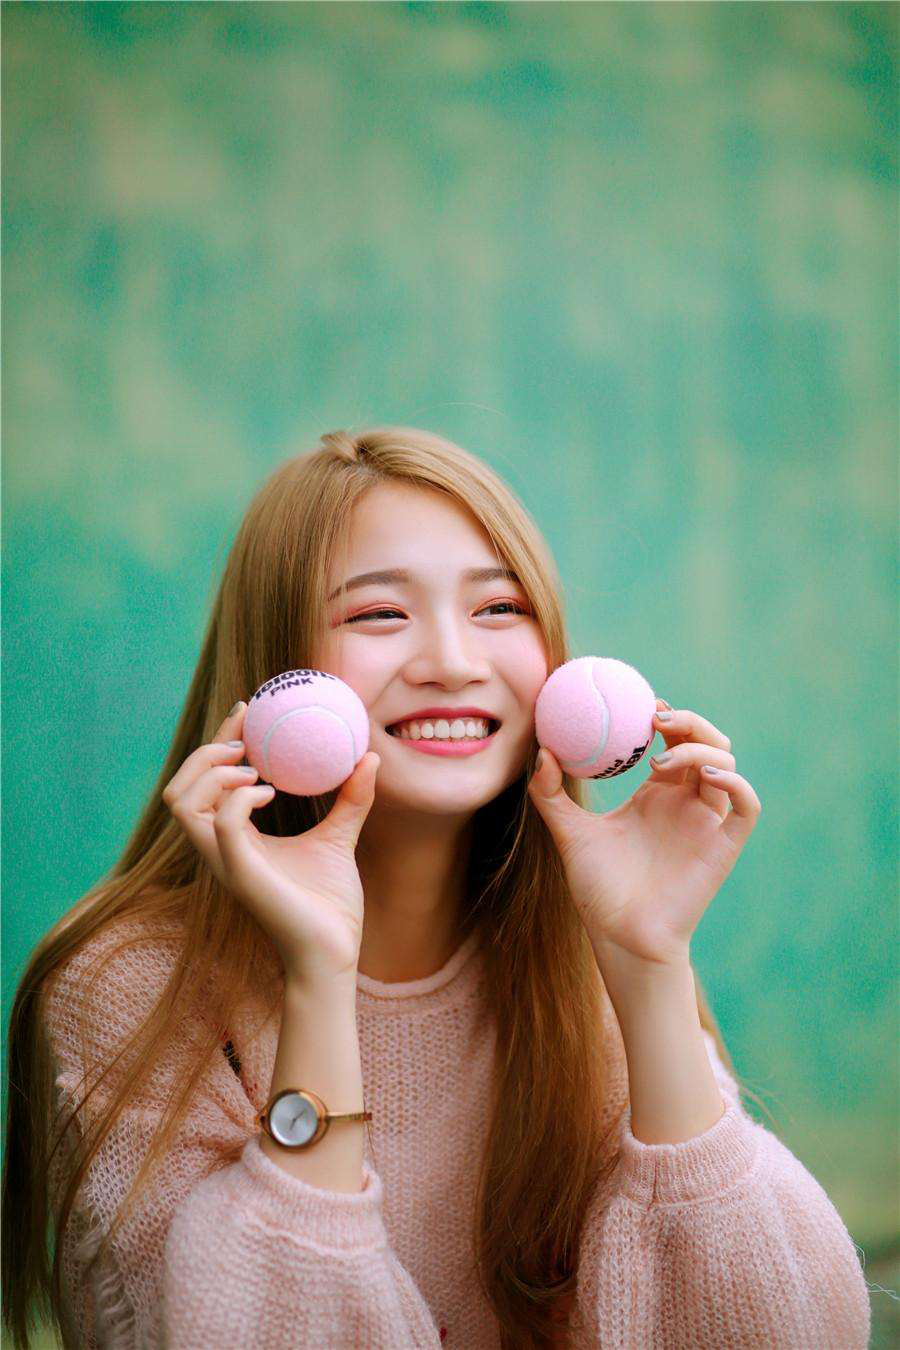

In [9]:
from PIL import Image
img = Image.open('D:\\colors\\tt\\1.jpg')
# img = Image.open('new.jpg')
img.size
img

In [10]:
# prepare for the input
transform = T.Compose([T.ToTensor()])
input_im = transform(img)

input_im = torch.unsqueeze(input_im, 0)
input_im.shape

torch.Size([1, 3, 1350, 900])

In [11]:
# Get the results from class
results = net(input_im)

## Display the results

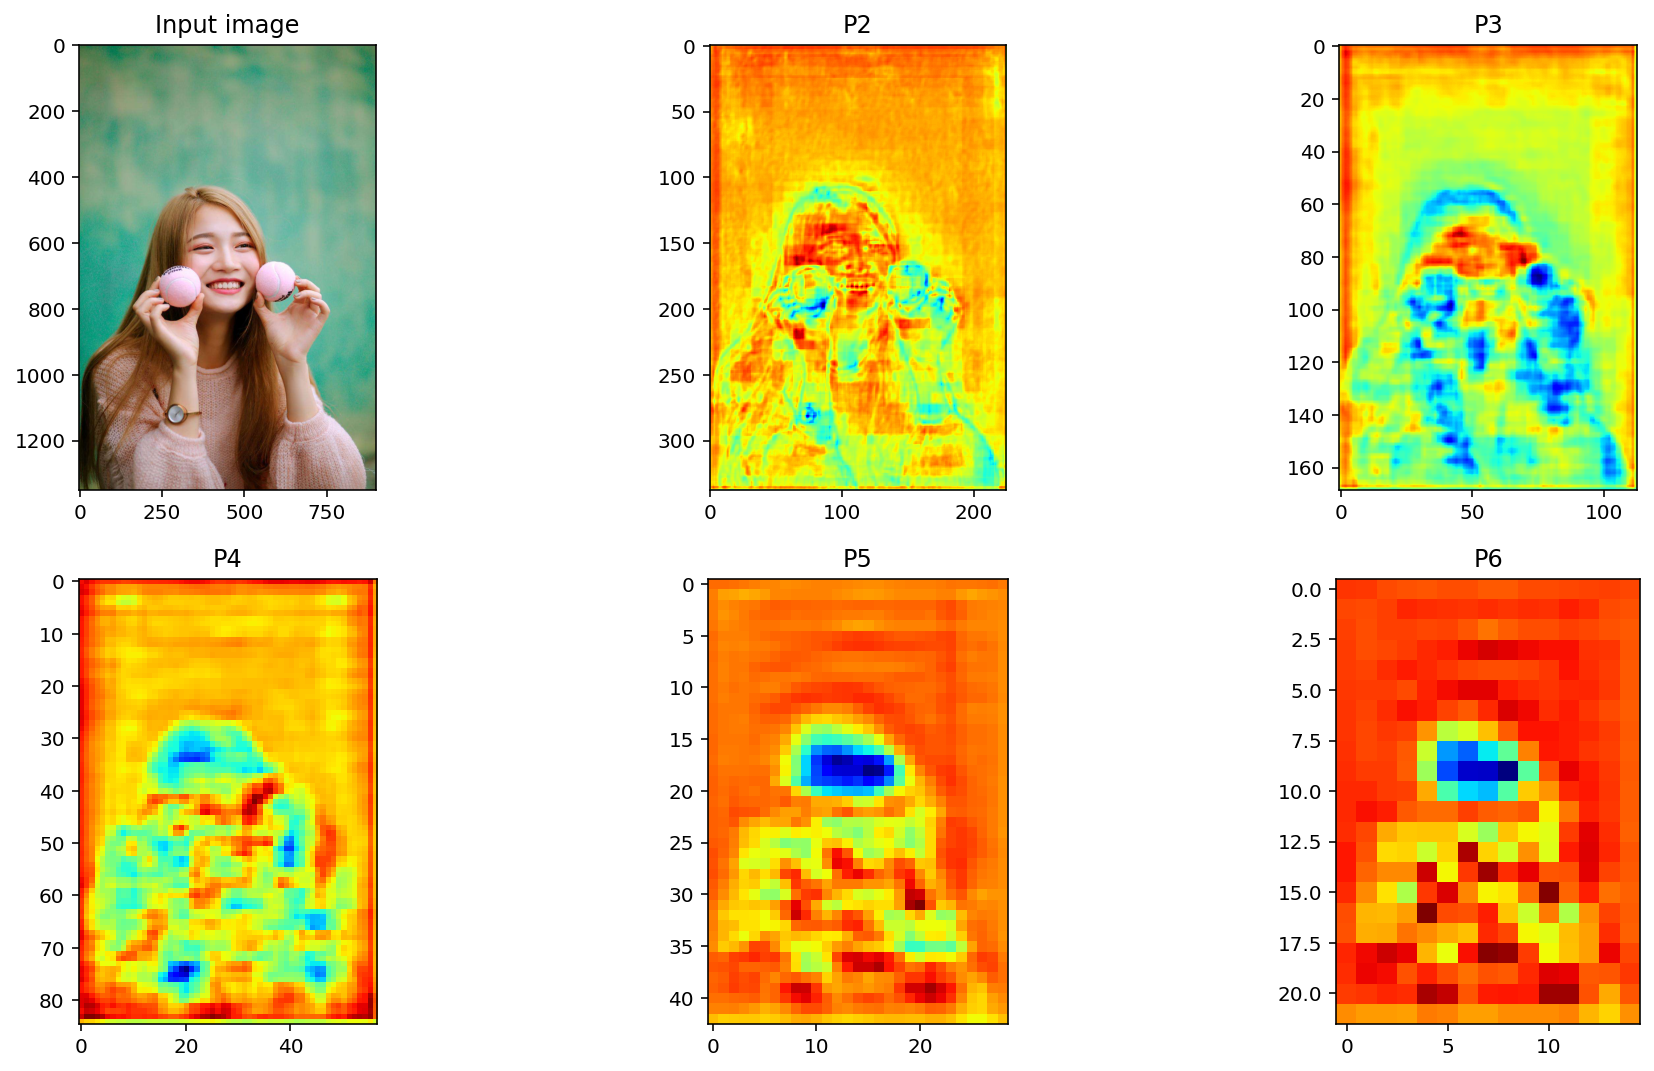

In [12]:
# Display feature maps
show_features(img, results['features'], 0, True)

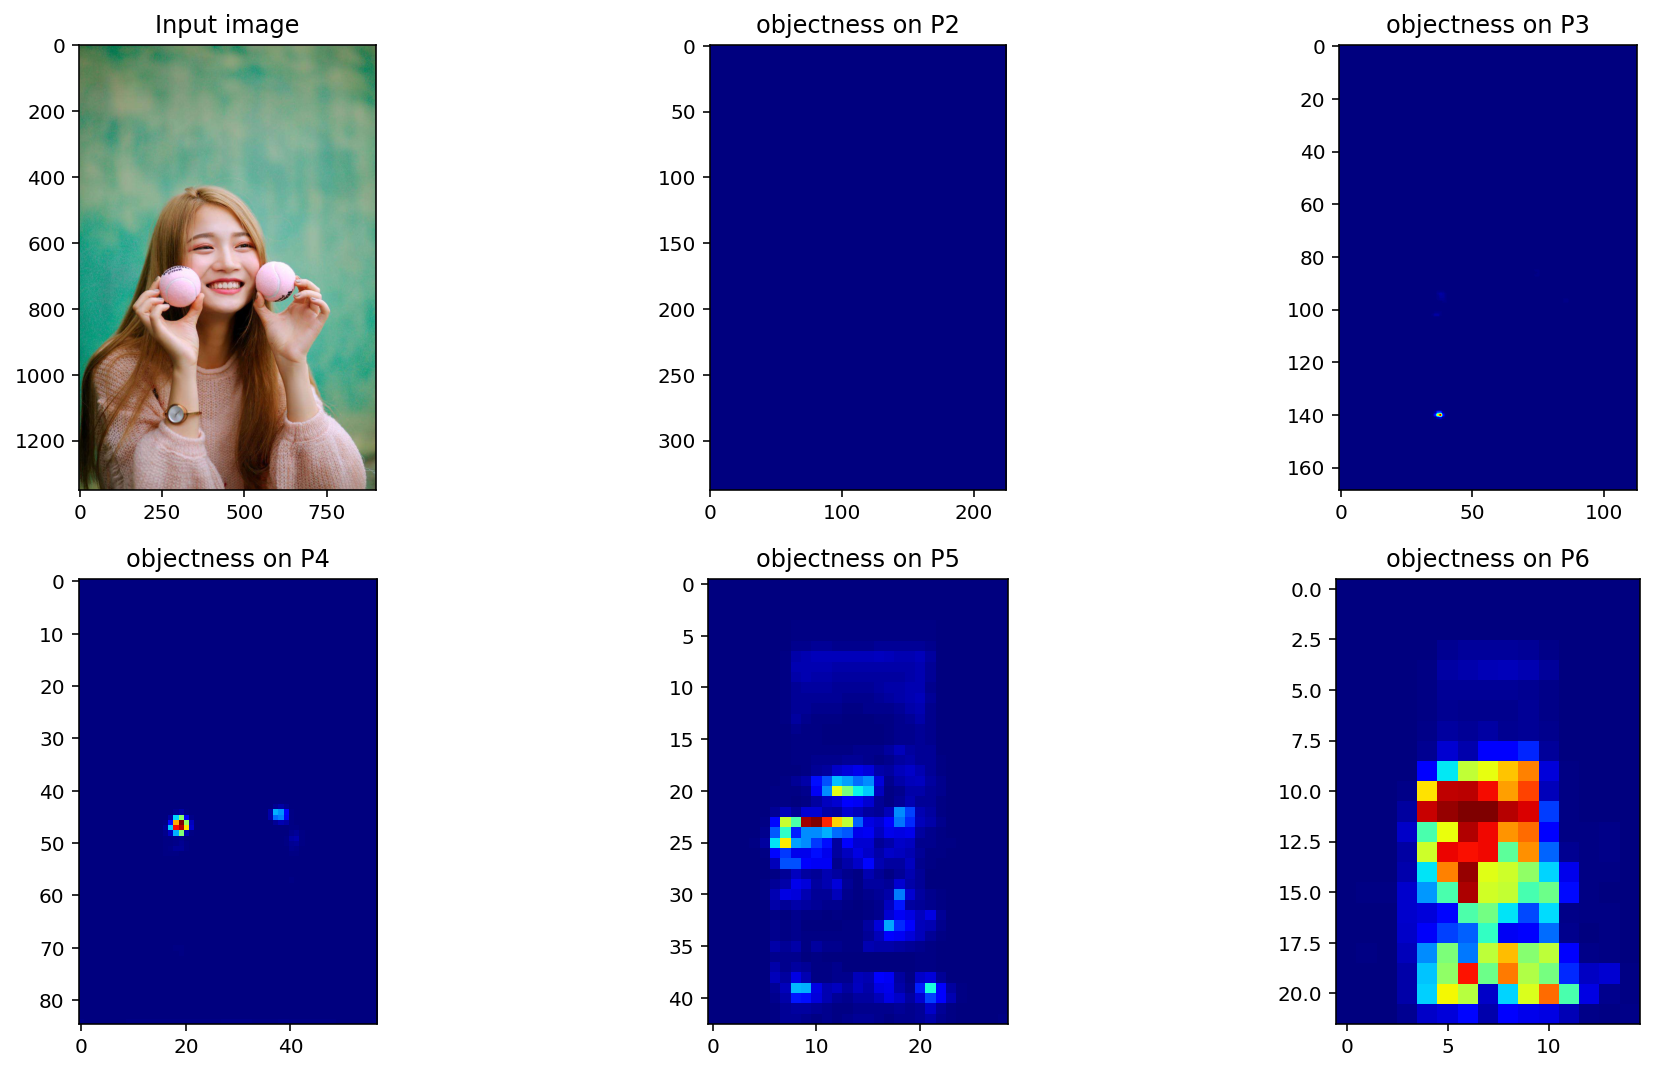

In [13]:
# Display the heat maps
show_objectness(img, results['objectness'], 0, True)

## Reference
### Get the objectness heatmap

> Figure 4. Visualization of objectness maps. Sigmoid function has been applied to the objectness_logits map. \
**The objectness maps for 1:1 anchor** are resized to the P2 feature map size and overlaid on the original image.

### Method mentioned by author:
>I just insert the following features here to save the objectness heatmap.
1. apply sigmoid and scale the tensor range to 0–255
2. choose a map from the tensor
3. convert it to numpy array (uint8)
4. save it as an image file (or directly visualize it using matplotlib)
> 
>If you use proper weights and proper input image, it should work :)